# Project Setup

In [100]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

import seaborn as sns
import time
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

quandl.ApiConfig.api_key = 'RtzgMLo48kkxxh9-sLuf'
data_dir = './data/'

# Retrieve Altcoin Pricing Data
Now that we have a solid time series dataset for the price of Bitcoin, let's pull in some data on non-Bitcoin cryptocurrencies, commonly referred to as altcoins.

## Define Poloniex API Helper Functions

For retrieving data on cryptocurrencies we'll be using the [Poloniex API](https://poloniex.com/support/api/).  To assist in the altcoin data retrieval, we'll define two helper functions to download and cache JSON data from this API.

First, we'll define `get_json_data`, which will download and cache JSON data from a provided URL.

In [101]:
def get_json_data(json_url, file_name):
    '''Download and cache JSON data, return as a dataframe.'''
    cache_path = '{}{}.pkl'.format(data_dir, file_name)
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(file_name))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached response at {}'.format(cache_path))
    return df

Next, we'll define a function to format Poloniex API HTTP requests and call our new get_json_data function to save the resulting data.

In [290]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015

end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

This function will take a cryptocurrency pair string (such as 'BTC_ETH') and return the dataframe containing the historical exchange rate of the two currencies.

## Download Trading Data From Poloniex
Most altcoins cannot be bought directly with USD; to acquire these coins individuals often buy Bitcoins and then trade the Bitcoins for altcoins on cryptocurrency exchanges.  For this reason we'll be downloading the exchange rate to BTC for each coin, and then we'll use our existing BTC pricing data to convert this value to USD.

We'll download exchange data for nine of the top cryptocurrencies -
[Ethereum](https://www.ethereum.org/), [Litecoin](https://litecoin.org/), [Ripple](https://ripple.com/), [Ethereum Classic](https://ethereumclassic.github.io/), [Stellar](https://www.stellar.org/), [Dashcoin](http://dashcoin.info/), [Siacoin](http://sia.tech/), [Monero](https://getmonero.org/), and [NEM](https://www.nem.io/).

In [291]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Cached response at ./data/BTC_ETH.pkl
Cached response at ./data/BTC_LTC.pkl
Cached response at ./data/BTC_XRP.pkl
Cached response at ./data/BTC_ETC.pkl
Cached response at ./data/BTC_STR.pkl
Cached response at ./data/BTC_DASH.pkl
Cached response at ./data/BTC_SC.pkl
Cached response at ./data/BTC_XMR.pkl
Cached response at ./data/BTC_XEM.pkl


Now we have a dictionary of 9 dataframes, each containing the historical daily average exchange prices between the altcoin and Bitcoin.

We can preview the last few rows of the Ethereum price table to make sure it looks ok.

In [292]:
altcoin_data['XEM']

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-03-31,1.600000e-06,1.020000e-04,7.100000e-07,2.500000e-06,5.961381e+07,97.319038,1.630000e-06
2015-04-01,9.800000e-07,1.870000e-06,7.000000e-07,1.580000e-06,2.384865e+08,264.991041,1.110000e-06
2015-04-02,1.230000e-06,1.300000e-06,9.100000e-07,1.000000e-06,9.577869e+07,112.841565,1.170000e-06
2015-04-03,1.220000e-06,1.310000e-06,1.150000e-06,1.220000e-06,6.581851e+07,81.295697,1.230000e-06
2015-04-04,1.070000e-06,1.250000e-06,9.900000e-07,1.240000e-06,8.535530e+07,92.888274,1.080000e-06
2015-04-05,8.900000e-07,1.120000e-06,8.400000e-07,1.090000e-06,1.088683e+08,102.780788,9.400000e-07
2015-04-06,1.130000e-06,1.160000e-06,8.800000e-07,8.900000e-07,8.084315e+07,88.110318,1.080000e-06
2015-04-07,9.600000e-07,1.120000e-06,9.200000e-07,1.120000e-06,5.678294e+07,57.056392,1.000000e-06
2015-04-08,9.300000e-07,1.020000e-06,9.100000e-07,9.700000e-07,2.971265e+07,28.261242,9.500000e-07


## Merge All Of The Pricing Data Into A Single Dataframe
Next, we will define a simple function to merge a common column of each dataframe into a new combined dataframe.

In [293]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

## Visualize The Pricing Datasets
The next logical step is to visualize how these pricing datasets compare.  For this, we'll define a helper function to provide a single-line command to compare each column in the dataframe on a graph using Plotly.

In [294]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

# Chart the prices

In [295]:
# Merge price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'weightedAverage')

# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (BTC)', seperate_y_axis=False, y_axis_label='Coin Value (BTC)', scale='linear')

# Feature Engineering
adds features for classification. First computes the change ratio of all features. This way the features become unitless. Then find the target labels by shifting the weightedAverage and comparing with average value.

In [310]:
# selecting the features of the given altcoin
df = altcoin_data['ETH'][['high', 'low', 'quoteVolume', 'volume', 'weightedAverage']]

# renaming the weightedAverage column
df = df.rename(columns={'weightedAverage': 'price'})

# disable panda warning
pd.options.mode.chained_assignment = None  # default='warn'


df['vol'] = df['volume']/df['quoteVolume']


# adding previous days weighted averages as new features
n = 3
for i in range(n):
    df['price-%d'%(i+1)] = df['price'].shift(i+1)
    df['vol-%d'%(i+1)] = df['vol'].shift(i+1)


# remove the first n samples since they don't have previous day data
df = df.drop(df.index[0:n])



df['price+'] = df['price'].shift(-1)

# remove the last sample since it does not have a tomorow sample
df = df.drop(df.index[-1])




df['volRate-2'] = df['vol-2']/df['vol-3'] - 1
df['volRate-1'] = df['vol-1']/df['vol-2'] - 1
df['volRate'] = df['vol']/df['vol-1'] - 1
df['volAcc'] = df['volRate'] - df['volRate-1']
df['volAcc-1'] = df['volRate-1'] - df['volRate-2']
df['volJerk'] = df['volAcc'] - df['volAcc-1']


df['priceRate-2'] = df['price-2']/df['price-3'] - 1
df['priceRate-1'] = df['price-1']/df['price-2'] - 1
df['priceRate'] = df['price']/df['price-1'] - 1
df['priceAcc'] = df['priceRate'] - df['priceRate-1']
df['priceAcc-1'] = df['priceRate-1'] - df['priceRate-2']
df['priceJerk'] = df['priceAcc'] - df['priceAcc-1']






df['priceRange'] = df['high']/df['low'] - 1





df['priceRate+'] = df['price+']/df['price'] - 1
df.head()

,high,low,quoteVolume,volume,price,vol,price-1,vol-1,price-2,vol-2,...,volAcc-1,volJerk,priceRate-2,priceRate-1,priceRate,priceAcc,priceAcc-1,priceJerk,priceRange,priceRate+
date,,,,,,,,,,,,,,,,,,,,,
2015-08-11,0.004400,0.002414,9.151385e+05,3007.274111,0.003286,0.003286,0.002524,0.002524,0.002860,0.002860,...,0.251033,0.168228,-0.368513,-0.117478,0.301782,0.419260,0.251035,0.168224,0.822701,0.276796
2015-08-12,0.004882,0.002910,1.117821e+06,4690.075032,0.004196,0.004196,0.003286,0.003286,0.002524,0.002524,...,0.419261,-0.444247,-0.117478,0.301782,0.276796,-0.024986,0.419260,-0.444246,0.677767,0.434592
2015-08-13,0.007999,0.004010,1.361099e+06,8192.675011,0.006019,0.006019,0.004196,0.004196,0.003286,0.003286,...,-0.024986,0.182782,0.301782,0.276796,0.434592,0.157796,-0.024986,0.182782,0.994763,0.264196
2015-08-14,0.008888,0.006500,1.531205e+06,11651.548987,0.007609,0.007609,0.006019,0.006019,0.004196,0.004196,...,0.157796,-0.328193,0.276796,0.434592,0.264196,-0.170396,0.157796,-0.328191,0.367385,-0.152852
2015-08-15,0.007205,0.005700,7.361567e+05,4745.484895,0.006446,0.006446,0.007609,0.007609,0.006019,0.006019,...,-0.170396,-0.246650,0.434592,0.264196,-0.152852,-0.417048,-0.170396,-0.246653,0.264049,-0.190604


# Correlation between features

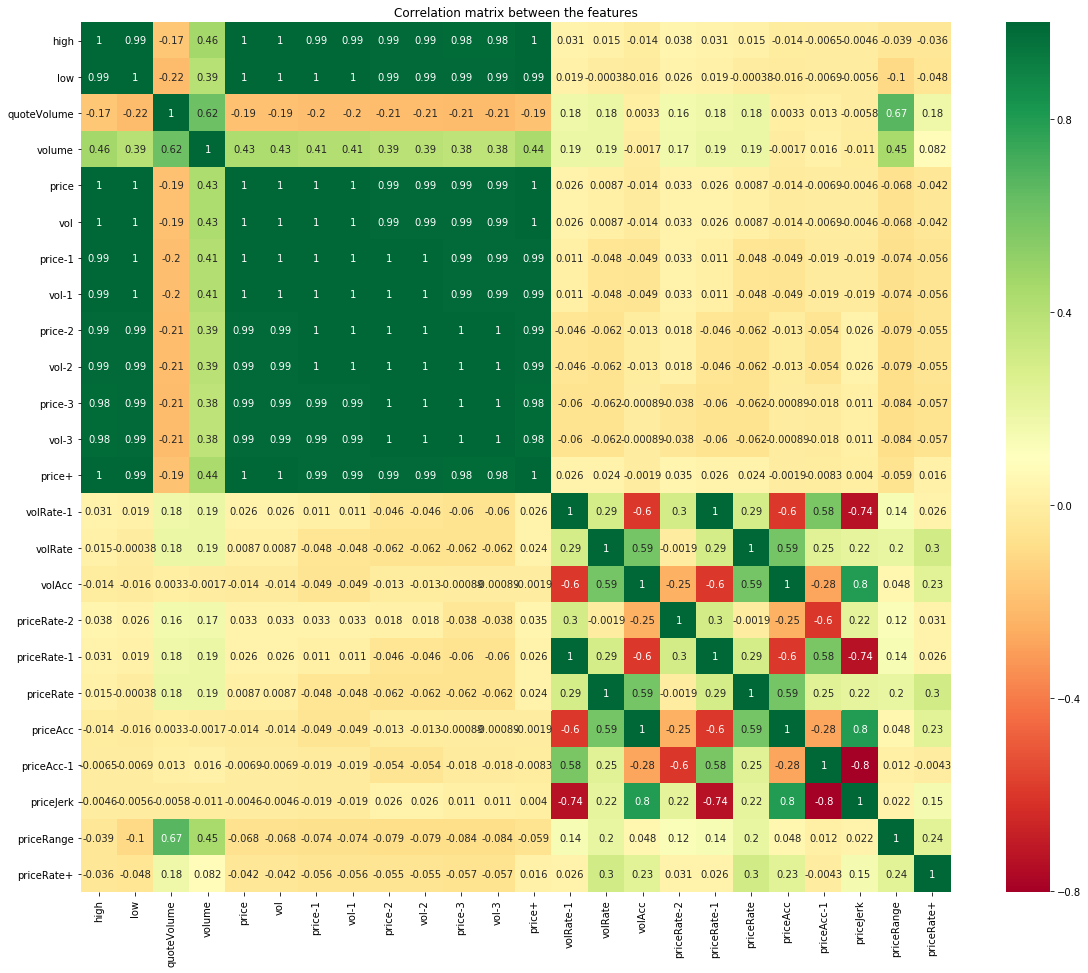

In [297]:
correlation_matrix = df.corr()
plt.figure(figsize=(20,16))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.show()

In [311]:
X = df[['volRate', 'priceRange', 'priceRate', 'priceAcc', 'priceJerk', 'volRate', 'volAcc', 'volJerk']]

X.head()

,volRate,priceRange,priceRate,priceAcc,priceJerk,volRate,volAcc,volJerk
date,,,,,,,,
2015-08-11,0.301782,0.822701,0.301782,0.419260,0.168224,0.301782,0.419261,0.168228
2015-08-12,0.276796,0.677767,0.276796,-0.024986,-0.444246,0.276796,-0.024986,-0.444247
2015-08-13,0.434592,0.994763,0.434592,0.157796,0.182782,0.434592,0.157796,0.182782
2015-08-14,0.264196,0.367385,0.264196,-0.170396,-0.328191,0.264196,-0.170396,-0.328193
2015-08-15,-0.152851,0.264049,-0.152852,-0.417048,-0.246653,-0.152851,-0.417046,-0.246650


# Target Labels

In [312]:
tomorrrowPriceChange = df['priceRate+'].values

# finds the median weighted price changes
priceChangeMed = np.median(tomorrrowPriceChange)
print('Median daily price change: %0.4f'%priceChangeMed)

# computes the target label as whether the tomorrow value exceeds the median
# in order to make the dataset balanced, i.e., number of pos and neg labels be equal
y = np.sign(tomorrrowPriceChange - priceChangeMed)
print('target labels matrix shape: ', y.shape)

Median daily price change: -0.0029
target labels matrix shape:  (886,)


# Preprocessing

In [313]:
# normalize the dataFrame
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

# Model selection

In [352]:
from sklearn.model_selection import train_test_split
 
from sklearn.ensemble import VotingClassifier   
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier    
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [359]:

dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators = 18),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    "Bagging-kNN": BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.8),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "Voting": VotingClassifier(estimators=[('1', KNeighborsClassifier()), ('-1', SVC())], voting='hard')
}


no_classifiers = len(dict_classifiers.keys())
def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,4)), columns = ['classifier', 'train_score', 'test_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'test_score'] = test_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results


In [360]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=1)
df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

trained Logistic Regression in 0.00 s
trained Nearest Neighbors in 0.00 s
trained Linear SVM in 0.02 s
trained Gradient Boosting Classifier in 0.12 s
trained Decision Tree in 0.01 s
trained Random Forest in 0.04 s
trained Neural Net in 0.50 s
trained Naive Bayes in 0.00 s
trained Bagging-kNN in 0.02 s
trained AdaBoost in 0.22 s
trained Voting in 0.02 s


,classifier,train_score,test_score,training_time
8,Bagging-kNN,0.664516,0.563910,0.020817
1,Nearest Neighbors,0.695161,0.552632,0.001181
10,Voting,0.569355,0.545113,0.019892
2,Linear SVM,0.558065,0.537594,0.019773
6,Neural Net,0.587097,0.533835,0.497851
9,AdaBoost,0.740323,0.522556,0.221414
4,Decision Tree,1.000000,0.518797,0.007157
3,Gradient Boosting Classifier,0.875806,0.515038,0.124811
5,Random Forest,0.996774,0.503759,0.042674
7,Naive Bayes,0.561290,0.503759,0.002596
